Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says "YOUR ANSWER HERE" or `YOUR CODE HERE` and remove the `raise NotImplementedError()` lines. 

Code blocks starting with a `# tests` comment provide unit tests which have to run without errors in order to get full points. Be aware that there might be further 'secret' tests to check correct implementation! I.e. the provided unit tests are necessary but not sufficient for full points!

You are always welcome to add **additional plots, tests, or debug outputs**.
However, make sure to: **1) not break the automated tests**, and **2) switch off any excessive debug output** when you submit your notebook!

Please add your name and student ID below:

In [1]:
NAME = "Konstantinos Vakalopoulos" 
STUDENT_ID = "12223236" 
# YOUR CODE HERE
# raise NotImplementedError()

In [2]:
assert len(NAME) > 0, "Enter your name!"
assert len(STUDENT_ID) > 0, "Enter your student ID!"

# Intelligent Audio and Music Analysis Assignment 2
## Onset Detection


The goal of this exercise is to understand the principles of onset detection. In this notebook we will build a signal-processing-based onset detection method, evaluate, and fine-tune it. This assignment accounts for **40 points for assignment block A** (100 points total).


## Data

We covered audio loading, processing, and spectrogram calculation already in the last assignment. So for this assignment, to keep things simple, the audio has already been preprocessed, and is provided as a ready-to-use dataset in numpy archives (.npz).
Let's load the data from these files:

In [3]:
# DO NOT COPY OR MODIFY THIS CELL!!
import numpy as np
import os
import traceback

dataset_path = os.path.join(os.environ['HOME'], 'shared', '194.039-2023W', 'data', 'assignment_2')
if os.path.exists('data.npz'):
    dataset_path = '.'
    
audio_sample_rate = 44100
spec_frame_rate = 100
spec_freq_bins = 40

audio_data = np.load(os.path.join(dataset_path, 'data.npz'), allow_pickle=True, mmap_mode='r')

onset_data = np.load(os.path.join(dataset_path, 'onsets.npz'), allow_pickle=True, mmap_mode='r')

print("contents of 'audio_data' archive: {}".format(audio_data.files))
print("contents of 'onset_data' archive: {}".format(onset_data.files))

contents of 'audio_data' archive: ['names', 'audio', 'spectrograms']
contents of 'onset_data' archive: ['annotations', 'audio_idxs']


The `audio_data` archives contain lists with the audio file names, the audio signal content (as PCM data),
and precalculated spectrograms.
The `onset_data` archive contains the onset annotations for each audio files.

We can get all data for an example at index `example_idx`, by using the code block below.

**Note:** The spectrograms were calculated using *madmom*. Since *scipy* and *madmom* use different dimensions for time and frequency (*scipy* 0:freq, *madmom* 0: time) the dimensions are assigned differently than in the last assignment.

In [4]:
example_idx = 205

In [5]:
# DO NOT COPY OR MODIFY THIS CELL!!
# get annotations from onset data archive:
example_onset_ann = onset_data['annotations'][example_idx]

# get the correct audio related data from the audio archive:
example_audio_name = audio_data['names'][example_idx]
example_audio = audio_data['audio'][example_idx]
example_spectrogram = audio_data['spectrograms'][example_idx]

# we can play the audio in this jupyter notebook
import IPython.display as ipd
print(f"audio shape: {str(example_audio.shape)}")
print(f"spectrogram shape: {str(example_spectrogram.shape)}")
print(f"audio for file : '{example_audio_name}'")
ipd.Audio(example_audio, rate=audio_sample_rate)

audio shape: (589885,)
spectrogram shape: (1338, 40)
audio for file : 'n/ff123_charlies'


## Signal Processing Based Onset Detection

For this assignment, onset detection should be implemented using the *spectral flux* (LogFiltSpecFlux) method discussed in the lecture.
In order to build this algorithm we have to implement the following steps:

0. Preprocessing of audio
1. Calculate the onset detection function (ODF)
2. Select onsets from ODF (peak picking)

Furthermore, we want to evaluate the performance of the implemented onset detection algorithm.
To do this, we need to implement the following things:
1. Detect onsets on test data
2. Evaluate onset detection performance

## Task 1: Onset Detection Function (6 Points)

Since the loading of audio and calculation of spectrograms was already done in advance, we can skip step 0 (preprocessing of audio).
The spectrograms are already frequency filtered and are in log values, so you do not have to worry about the 'LogFilt' aspect.
The next thing to take care of, is the calculation of our ODF.
As discussed in the lecture, the steps to calculate the *spectral flux* ODF are:
1. Compute first order spectral differences over time dimension 
   (i.e. differences between two neighbouring spectrogram frames)
2. Keep only positive differences
3. Sum differences over frequency dimension

### 1.1 Implement ODF

**Implement the algorithm** described above, in the blank function below.

**Hint:** numpy provides functions for all these operations out-of-the-box!

In [6]:
def onset_detection_function(spectrogram):
    """
    Compute an onset detection function.

    Parameters
    ----------
    spectrogram : numpy.ndarray
        Spectrogram, dimension 0: time, dimension 1: frequency

    Returns
    -------
    odf : numpy.ndarray
        Onset detection function. Size of dimension 0 maches spectrogram dimension 0.

    """
    odf = 0
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    spectral_diff = np.diff(np.abs(spectrogram), axis=0)
    positive_diff = np.maximum(spectral_diff, 0)
    odf = np.sum(positive_diff, axis=1)

    odf = np.insert(odf,0,0)

    
    return odf

In [7]:
# helper for tests, DO NOT COPY OR MODIFY THIS CELL!!
def test_mats(real, expected):
    assert len(real) == len(expected) and \
       np.allclose(real, expected), \
        "test failed: real {} expected {}".format(real, expected)

In [8]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
assert onset_detection_function(example_spectrogram).shape[0] == example_spectrogram.shape[0], "ODF must have the same lenght as spectrogram!!"
    
test_specgram = np.zeros((100, 40))
expected_odf = np.zeros((100, ))
test_mats(onset_detection_function(test_specgram), expected_odf)

test_specgram[10, :] = 1
expected_odf[10] = 40
test_mats(onset_detection_function(test_specgram), expected_odf)

score = 1
try:
    test_specgram[20, :3] = 10
    test_specgram[21, 3:4] = 10
    test_specgram[22, :6] = 10
    expected_odf[20] = 30
    expected_odf[21] = 10
    expected_odf[22] = 50
    test_mats(onset_detection_function(test_specgram), expected_odf)
    print('All tests successful!')
    score+=1
except:
    traceback.print_exc()
    print(f'Some tests failed!')


All tests successful!


### 1.2 Plot ODF 
**Plot the ODF** for the example we picked in the very beginning of the notebook (`example_spectrogram`). **Plot the spectrogram**, as we did in assignment 1, with aligned x-axes.
In order to be able to see details, **only plot the first 5 seconds** of both the spectrogram and ODF.

<Figure size 1200x800 with 0 Axes>

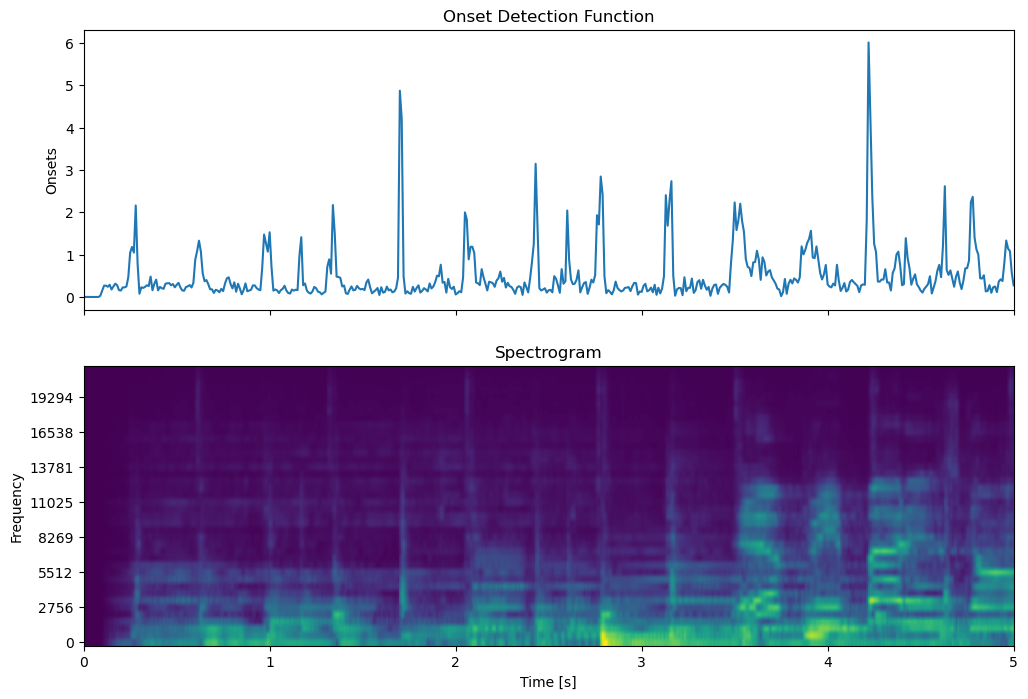

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
# Hint: Use plt.subplot() to align x-axes (sharex parameter), do not forget proper axis labeling!
# YOUR CODE HERE
odf = onset_detection_function(example_spectrogram)
bins = spec_freq_bins
frame_rate = spec_frame_rate
frame = list(range(len(odf)))
time = [i/frame_rate for i in frame]
spectrogram = example_spectrogram.T

fraction = [i/bins for i in range(40)]
frequency = [round(frac*audio_sample_rate/2) for frac in fraction]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
# spectrogram -> example_spectrogram   

ax1.plot(odf)
ax1.set_title("Onset Detection Function")
ax1.set_ylabel("Onsets")


ax2.imshow(spectrogram, origin='lower', aspect='auto')

ax2.set_title("Spectrogram")  
ax2.set_ylabel("Frequency")

ax2.set_xticks(range(0,501,100))
ax2.set_xticklabels(range(6))

ax2.set_yticks(range(0,40,5))
ax2.set_yticklabels(frequency[0:40:5])

plt.xlabel("Time [s]")
plt.xlim(0,500)
plt.show()

In [10]:
# hidden tests, DO NOT COPY OR MODIFY THIS CELL!!
pass

## Task 2: Peak Picking (14 Points)

Ideally our onset detection function has high and narrow peaks at the positions of the onset of audio events in the signal. However, there will also be quite some noise. In order to identify the correct peaks which represent onsets, we need a peak picking algorithm. To select the onsets in the ODF, the following procedure should be applied:

1. Calculate a moving average from the ODF
2. Discard all values in the ODF which are below the moving average plus a certain threshold
3. Find local maxima
4. Discard local maxima which are too close together

**Note:** You do not need to implement the required mean and max filters yourself, you can use filter implementations e.g. from [scipy](https://docs.scipy.org/doc/scipy/reference/ndimage.html) (`scipy.ndimage.*_filter`).

### 2.1 Moving Average

**Implement a function** that uses a small moving window to perform mean filtering (uniform filter) on the ODF and return the resulting moving average.
If a `filter_size <= 1` or `None` is provided, return an array with all zeros and same shape as `odf`.

In [11]:
def moving_average(odf, filter_size):
    """
    Apply a moving average with size filter_size to odf

    Parameters
    ----------
    odf : numpy.ndarray
        Onset detection function
    filter_size : int
        Kernel size for mean filter

    Returns
    -------
    mov_avg : numpy.ndarray
        Result of applying the moving average filter to the onset detection function odf

    """
    mov_avg = 0
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    mov_avg = np.zeros(len(odf))
    if filter_size > 1 and np.any(odf):

        for i in range(0, len(odf), filter_size):
            window = odf[i:i+filter_size]
            avg = sum(window) / len(window)
            mov_avg[i:i+filter_size] = avg

        '''
        pad_width = filter_size // 2
        padded_data = np.pad(odf, (pad_width, pad_width), mode='constant')
        mov_avg = np.convolve(padded_data, np.ones(filter_size) / filter_size, mode='valid')
        '''
    return mov_avg

In [12]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
    
test_odf = np.zeros((100, ))
expected_avg = np.zeros((100, ))
test_mats(moving_average(test_odf, 10), expected_avg)

test_odf[10] = 9
expected_avg[9:12] = 3
test_mats(moving_average(test_odf, 3), expected_avg)
print('All tests successful!')

All tests successful!


### 2.2 Thresholding

**Implement the thresholding function.**
Use the moving average (`mov_avg`) and the provided threshold value to set values of `odf` that are below `mov_avg+threshold` to zero and returned this thresholded version of `odf`.

In [13]:
def apply_threshold(odf, mov_avg, threshold):
    """
    Apply thresholding to odf, using mov_avg and threshold.

    Parameters
    ----------
    odf : numpy.ndarray
        Onset detection function
    mov_avg : numpy.ndarray
        Moving average of odf
    threshold : float
        Threshold value

    Returns
    -------
    thresh_odf : numpy.ndarray
        Result of applying the thresholding on odf.

    """
    thresh_odf = 0
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    thresh_odf = np.array([odf[i] if odf[i] >= (mov_avg[i] + threshold) else 0 for i in range(len(odf))])

    return thresh_odf


In [14]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

test_odf = np.zeros((100, ))
expected_thresh = np.zeros((100, ))
test_mats(apply_threshold(test_odf, moving_average(test_odf, 5), 1), expected_thresh)

test_odf[10] = 9
expected_thresh[10] = 9
test_mats(apply_threshold(test_odf, moving_average(test_odf,3), 1), expected_thresh)
print('All tests successful!')

All tests successful!


### 2.3 Finding Maxima

In the next step we need to find the local maxima in the thresholded ODF.
A simple way to achieve this, is to apply a moving maximum filter. Then, the positions at which the ODF is equal to the output of the maximum filter, represent local maxima (i.e. peaks).
Use the provided `filter_size` as filter/kernel size for the maximum filter.

**Implement the `find_maxima` function** using the described algorithm above, and **return the indices** of the found local maxima (peaks).

**Hint:** Take a look at numpy's [nonzero](https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html#numpy.nonzero) or [argwhere](https://numpy.org/doc/stable/reference/generated/numpy.argwhere.html).

In [15]:
from scipy.ndimage import maximum_filter

def find_maxima(odf, filter_size):
    """
    Find maxima by applying a moving maximum filter.

    Parameters
    ----------
    odf : numpy.ndarray
        Onset detection function
    filter_size : int
        Kernel size for maximum filter

    Returns
    -------
    peak_idxs : numpy.ndarray
        Indices of the detected peaks.

    """
    peak_idxs = None

    # YOUR CODE HERE
    '''
    peak_idxs = []
    if filter_size > 1 and np.any(odf):
        for i in range(0, len(odf), filter_size):
            window = odf[i:i+filter_size]
            if np.max(window) != 0:
                peak = np.argwhere(odf == max(window))
                peak_idxs.append(peak)
    '''
    max_filtered_data = maximum_filter(odf, size=filter_size)
    peak_idxs = np.argwhere((odf == max_filtered_data) & (odf != 0))

    return peak_idxs

In [16]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
    
test_odf = np.zeros((100, ))
test_mats(find_maxima(test_odf, 3), [])

test_odf[50] = 1
test_mats(find_maxima(test_odf, 3), [50])

test_odf[51] = 0.9
test_mats(find_maxima(test_odf, 3), [50])
print('All tests successful!')

All tests successful!


### 2.4 Merge Close Peaks
Peaks that are close together, e.g. in two neighboring frames, should be merged into one peak.
The next function should perform this operation. The **distance in frames between two peaks must be greater** than `delta`, if that is not the case, remove the second peak.
**Implement the function** `combine_events` that greedily removes peaks from the list if the distance to the previous peak is smaller or equal to `delta`.

If `delta` is `None` or smaller than one, or the list of peaks contains less than two elements, return the original list unchanged. 

In [17]:
def combine_events(peak_idxs, delta):
    """
    Combine detected peaks if they are within delta.

    Parameters
    ----------
    peak_idxs : list[int]
        Indices of the detected peaks.
    delta : int
        Distance (indices) within peaks should be merged.

    Returns
    -------
    events : numpy.ndarray
        Indices of the merged events.

    """
    events = None
    # YOUR CODE HERE
    # raise NotImplementedError()
    if delta == None or delta < 1 or len(peak_idxs)<2:
        events =  peak_idxs
    else:
        events = []
        for peak in peak_idxs:
            if not events or peak - events[-1] > delta:
                events.append(peak)

    return events

In [18]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
    
test_mats(combine_events([], 2), [])
test_mats(combine_events([0, 1], None), [0, 1]) 
test_mats(combine_events([0, 1], 3), [0])
test_mats(combine_events([0, 1, 3, 4], 3), [0, 4])
print('All tests successful!')

All tests successful!


### 2.5 Peak Picking Function

**Use the functions we implemented in tasks 2.1 - 2.4 to implement** the peak picking function (`detect_onsets`).
Note that for the output, we want to have the onset positions in seconds, rather than in frames.

**Note:** Do not change the default values for parameters in order to not break automated tests! <br>


In [19]:
# DO NOT COPY OR MODIFY THIS CELL!!
DEFAULT_AVG_KERNEL = 3
DEFAULT_MAX_KERNEL = 3
DEFAULT_THRESHOLD = 0.5
DEFAULT_COMB_DELTA = 2

In [20]:
def detect_onsets(odf, frame_rate=spec_frame_rate, **kwargs):
    """
    Detect the onsets in the onset detection function (odf).

    Parameters
    ----------
    odf : numpy array
        Onset detection function.
    frame_rate : float
        Frame rate of the onset detection function.
    kwargs : dict, optional
        Additional keyword arguments.

    Returns
    -------
    onsets : numpy.ndarray
        Detected onset positions (in seconds!).

    """  
    # get peak picking parameters from kwargs:
    avg_kernel = kwargs.get('avg_kernel', DEFAULT_AVG_KERNEL)
    threshold = kwargs.get('threshold', DEFAULT_THRESHOLD)
    max_kernel = kwargs.get('max_kernel', DEFAULT_MAX_KERNEL)
    delta = kwargs.get('comb_delta', DEFAULT_COMB_DELTA)


    # steps
    # 1. calc moving average
    # 2. apply threshold
    # 3. find peaks in odf with threshold
    # 4. remove close peaks
    # 5. convert from frame idx to seconds
    # YOUR CODE HERE
    
    # Step 1
    ma = moving_average(odf, avg_kernel)

    # Step 2
    threshold_odf = apply_threshold(odf, ma, threshold)
    
    # Step 3
    peaks = find_maxima(threshold_odf, max_kernel)

    # Step 4
    combined_peaks = combine_events(peaks, delta)

    # Step 5
    onsets_sec = [x[0]/frame_rate for x in combined_peaks]
    
    debug = kwargs.get('debug', False)
    if debug:
        # This block belongs to Task 2.6
        # ------------------------------
        # Create a plot that helps for debugging and optimizing peak picking parameters:
        # Plot the ODF and on top: 1) the floating average + threshold, 2) thresholded ODF,
        # 3) found peaks, as well as 4) merged onsets (after combine_events).
        plt.figure(figsize=(12, 8))

        # YOUR CODE HERE
        # raise NotImplementedError()
        frame = list(range(0,501,100))
        time = [int(i/frame_rate) for i in frame]
        
        plt.plot(odf, label='ODF')
        plt.plot(ma, label='Floating Average', linestyle='--')
        plt.axhline(y=threshold, color='r', linestyle=':', label='Threshold')
        plt.plot(range(len(odf)), threshold_odf,color = 'g',   label='Thresholded ODF')
        plt.scatter(peaks, [threshold_odf[i] for i in peaks], c='y', marker='o', label='Peaks')
        plt.scatter(combined_peaks, [threshold_odf[i] for i in combined_peaks], c='r', marker='o', label='Combined Peaks')

        plt.legend(loc='upper center')
        plt.title('Overlay of ODF with Elements')
        plt.tight_layout()
        plt.xlim(0,501)
        plt.xticks(frame, time)
        plt.xlabel("Time [s]")
        plt.ylabel("Onsets")
        plt.show()
    return onsets_sec

In [21]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

pp_test_data = np.zeros((200,))
detected_onsets = detect_onsets(pp_test_data)
assert len(detected_onsets) == 0, "no onsets expected for all zeros!"

pp_test_data[100] = 10
pp_test_data[101] = 8
test_mats(detect_onsets(pp_test_data), np.asarray([1.]))

pp_test_data[150] = 6
test_mats(detect_onsets(pp_test_data), np.asarray([1., 1.5]))
print('All tests successful!')


All tests successful!


### 2.6 Debug Plot for Peak Picking
Whenever we have to optimize a couple of parameters, having visualizations about what is going on, helps a lot.
In order to do this for our peak picking algorithm, implement the plotting under `if debug:` in the `detect_onset` function from task 2.5.
When correctly implemented, we can plot the ODF alongside the moving average + threshold, and the found peaks of our example here.

**Hint**: You can plot only markers by changing the style of the plot see [plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) documentation.

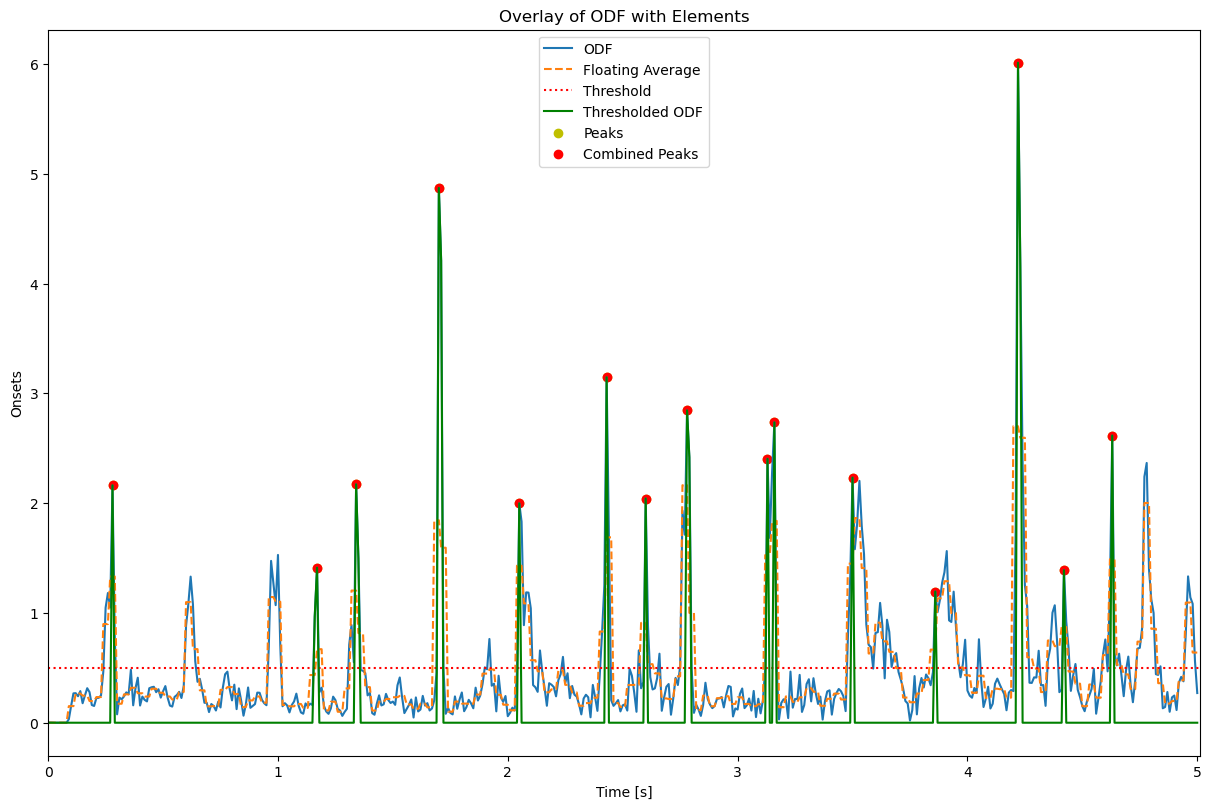

detected onsets: [0.28, 1.17, 1.34, 1.7, 2.05, 2.43, 2.6, 2.78, 3.13, 3.16, 3.5, 3.86, 4.22, 4.42, 4.63]


In [22]:
# DO NOT COPY OR MODIFY THIS CELL!!
example_spec_snippet = example_spectrogram[:501, :]
example_odf = onset_detection_function(example_spec_snippet)
onsets = detect_onsets(example_odf, frame_rate=spec_frame_rate, debug=True)
print("detected onsets: {}".format(onsets))

In [23]:
# hidden tests, DO NOT COPY OR MODIFY THIS CELL!!

## Task 3: Predict Onsets on Data Set (4 Points)

Now that we have all pieces to actually perform onset detection, apply everything for all audio files in the data set.
**Implement the missing part in `predict_onsets_for_all`**:
1. Take spectrogram from list
2. Calculate ODF using `onset_detection_function`
3. Detect the peaks using `detect_onsets` (forward the `**kwargs` to `detect_onsets`)!
4. Add list of onsets for each audio file to results list (`detected_onsets`)
5. Return results list

In [24]:
def predict_onsets_for_all(spectrograms=audio_data['spectrograms'], **kwargs):
    """
    Predict onsets for all spectrograms in the list spectrograms.

    Parameters
    ----------
    spectrograms : list[numpy.ndarray]
        List of spectrograms to be processed.
    kwargs : dict, optional
        Additional keyword arguments.

    Returns
    -------
    detected_onsets : list[numpy.ndarray]
        List of detected onset positions (in seconds!) for each spectrogram.

    """
    # list for collecting the onset detections, sorted in the same way 
    detected_onsets = []
 
    for spectrogram in spectrograms:
        # onsets = ...
        # NOTE: forward the **kwargs to detect_onsets
        # YOUR CODE HERE

        # Step 1
        odf = onset_detection_function(spectrogram)

        # Step 2
        onsets = detect_onsets(odf,**kwargs)

        # Step 3
        detected_onsets.append(onsets)
    
    return detected_onsets

In [25]:
# DO NOT COPY OR MODIFY THIS CELL!!
detected_onsets = predict_onsets_for_all()

In [26]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
assert len(detected_onsets) == len(onset_data['annotations']) , \
    "There should be {} lists of onsets but there are {} in the list!".format(len(onset_data['annotations']), len(detected_onsets))

print('All tests successful!')

All tests successful!


## Task 4: Evaluate Detected Onsets (8 Points)

Evaluate onset detection performance with `precision`, `recall`, and `fmeasure`.
Either use the `mir_eval` [package](https://craffel.github.io/mir_eval/) or the `madmom.evaluate.onsets` [module](https://madmom.readthedocs.io/en/v0.16.1/modules/evaluation/onsets.html).
**Implement the calculation of the performance metrics** for each pair of detections and annotations, and then **compute the mean** for each metric over all files (=macro evaluation).
As an evaluation tolerance window, ±30ms should be used.

In [27]:
# DO NOT COPY OR MODIFY THIS CELL!!
DEFAULT_TOLERANCE = 0.030

In [28]:
import madmom

def evaluate_onsets(onsets, annotations, tolerance=DEFAULT_TOLERANCE):
    """
    Evaluate detected onsets against ground truth annotations.

    Parameters
    ----------
    onsets : list[numpy.ndarray]
        List with detected onsets for all files.
    annotations : list[np.ndarray]
        List with corresponding ground truth annotations.
    tolerance : float
        Tolerance window in seconds to be used for evaluation.

    Returns
    -------
    precision : float
        Averaged precision.
    recall : float
        Averaged recall.
    fmeasure : float
        Averaged f-measure.

    """
    mean_precision = 0.0
    mean_recall = 0.0
    mean_fmeasure = 0.0
    
    import warnings  # NOTE: mir_eval and madmom throw warnings for empty detections / annotations, 
                     # we have to ignore those warnings, otherwise the notebook validation will fail!
                     # To do so, keep your code within this "with warnings.catch_warnings():" clause.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        for detection, annotation in zip(onsets, annotations):
            pass
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    precision = []
    recall = []
    f_measure = []

    for detection, annotation in zip(onsets, annotations): 
            
        tp, fp, tn, fn, errors = madmom.evaluation.onsets.onset_evaluation(detection, annotation, window=tolerance)
            
        tp = len(tp)
        fp = len(fp)
        fn = len(fn)
        
        if tp == 0 & fp == 0 & fn == 0:
            precision.append(1)
            recall.append(1)
            f_measure.append(1)
        else:
            precision.append(tp / (tp + fp))
            recall.append(tp / (tp + fn))
            f_measure.append(2*tp/(2*tp + fp + fn))
            
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_fmeasure = np.mean(f_measure)
    
    return mean_precision, mean_recall, mean_fmeasure

In [29]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
test_mats(evaluate_onsets([[]], [[]], 0.025), (1.0, 1.0, 1.0))

test_mats(evaluate_onsets([[1.0]], [[1.0]], 0.025), 
          (1.0, 1.0, 1.0))
test_mats(evaluate_onsets([[0.02, 3.5]], [[0.04, 3.55]], 0.025), 
          (0.5, 0.5, 0.5))
test_mats(evaluate_onsets([[0.02, 3.5]], [[0.04, 3.55]], 0.1), 
          (1.0, 1.0, 1.0))

test_mats(evaluate_onsets([[1,   2.2, 3,   4.3, 4.9, 6],
                           [1,   3,   3.5, 4.5, 4.6],
                           [1]], 
                          [[1,   2,   3,   4,   5,   6], 
                           [1,   2,   3,   4,   5,   6], 
                           [1,   2,   3,   4,   5,   6]], 0.1), 
          (31/45, 7/18, 304/693))
print('All tests successful!')

All tests successful!


Now let's run the evaluation of our detected onsets against the ground truth annotations:

In [30]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
precision, recall, fmeasure = \
    evaluate_onsets(detected_onsets, onset_data['annotations'], DEFAULT_TOLERANCE)

print(f'Onset detection results\nPrecision: {precision:.3f}\nRecall:    {recall:.3f}\nF-measure: {fmeasure:.3f}')

score = 1
try:
    assert precision > 0.3 and recall > 0.3 and fmeasure > 0.3, "Your implementation with default values did not reach the performance goal!"
    score += 1
    assert precision > 0.4 and recall > 0.4 and fmeasure > 0.4, "Your implementation with default values did not reach the performance goal!"
    
    # using default values provided for parameters and correct implementation, 
    # you should get at least 0.5 fmeasure at this point...
    score += 1
    assert precision > 0.5 and recall > 0.5 and fmeasure > 0.5, "Your implementation with default values did not reach the performance goal!"
    score += 1
    print(f'All tests successful! score: {score}/4 pts')
except:
    traceback.print_exc()
    print(f'Some tests failed! score: {score}/4 pts')
score

Onset detection results
Precision: 0.894
Recall:    0.619
F-measure: 0.693
All tests successful! score: 4/4 pts


4

## Task 5: Optimize Performance (8 Points)

When implementing the functions for our onset detection algorithm, we introduced a lot of parameters, like the kernel sizes for the mean and max filters, detection threshold, and minimal distance between detected onsets.
In order to get a good onset detector, we have to tune those parameters in a way that results in the best performance on the available data (highest f-measure).

In order to do this, without breaking the above tests, use the keyword arguments of the `detect_onsets` function (`**kwargs`) as parameters for the individual steps.
Keyword arguments are basically a dictionary of named parameters.
In a function call you can provide them by specifying a name-value pair, e.g.:
`detect_onsets(odf, threshold=0.5)`
And in the function you can retrieve them, using a default fallback value with:
`threshold = kwargs.get('threshold', DEFAULT_TRHESHOLD)`
where the first parameter of the get statement (`'threshold'`) is the argument name. The second parameter (`DEFAULT_TRHESHOLD`) is the default fallback value if no keyword argument with this name was specified.

Use the code block below to call `predict_onsets_for_all` with proper keyword arguments for our peak picking algorithm (`threshold`, `max_kernel`, `avg_kernel`, and `comb_delta`).
**Note**: In order for the **keyword arguments to have an effect** you need to forward the `**kwargs` in `predict_onsets_for_all` to `detect_onsets`, as stated in the comments.

Also, call `detect_onsets` directly with the `debug=True` argument once. This allows us to use the debug plot for peak picking from task 2.6 to visualize and help understand the effects of changing the peak picking parameters!

**Hint**: Precision and recall are valuable indicators in which direction to tune the parameters: if your precision is low, there are too many detected onsets; if you recall is low, there are too few.

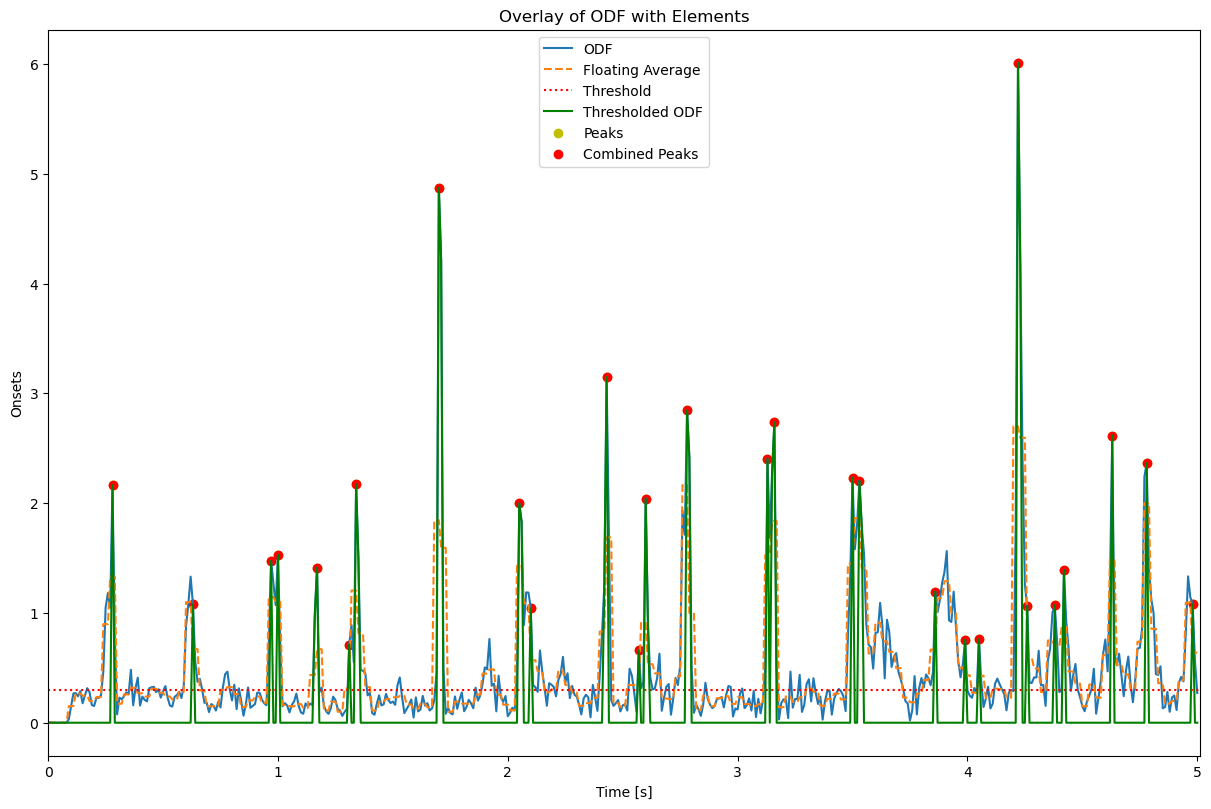

[0.28,
 0.63,
 0.97,
 1.0,
 1.17,
 1.31,
 1.34,
 1.7,
 2.05,
 2.1,
 2.43,
 2.57,
 2.6,
 2.78,
 3.13,
 3.16,
 3.5,
 3.53,
 3.86,
 3.99,
 4.05,
 4.22,
 4.26,
 4.38,
 4.42,
 4.63,
 4.78,
 4.98]

In [31]:
# predict onsets with new parameters:
# better_detected_onsets = predict_onsets_for_all( < add your keyword arguments here! >)
# show a debug plot for new parameters:
# detect_onsets(example_odf, frame_rate=spec_frame_rate, debug=True, < add your keyword arguments here! >)

# YOUR CODE HERE
'''
DEFAULT_AVG_KERNEL = 3
DEFAULT_MAX_KERNEL = 3
DEFAULT_THRESHOLD = 0.5
DEFAULT_COMB_DELTA = 2
'''

'''
We noticed that from the initial data and with the default parameters, many of the peaks are not being selected. 
This was due to the fact that the threshold was relatively high. So, in order to reduce precision and increase 
recall, we needed to slightly decrease the threshold and keep the rest of the parameters as they are. According 
to the task 5, if our precision is low, there are too many detected onsets and if our recall is low, there are too few.
'''

avg_k = 3
t = 0.3
max_k = 3
d = 2
better_detected_onsets = predict_onsets_for_all(avg_kernel = avg_k,
                                                threshold = t,
                                                max_kernel = max_k,
                                                comb_delta = d)
detect_onsets(example_odf, frame_rate=spec_frame_rate, debug=True,
              avg_kernel = avg_k,
              threshold = t,
              max_kernel = max_k,
              comb_delta = d)

In [32]:
# hidden tests, DO NOT COPY OR MODIFY THIS CELL!!

In [33]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
# evaluate detected onsets against ground truth annotations...
precision_b, recall_b, fmeasure_b = \
    evaluate_onsets(better_detected_onsets, onset_data['annotations'])

print(f"Improved onset detection results:\nPrecision: {precision_b:.3f}\nRecall:    {recall_b:.3f}\nF-measure: {fmeasure_b:.3f}")

score = 1
try:
    assert precision_b > 0.5 and recall_b > 0.5 and fmeasure_b > 0.5, "Your implementation with tuned parameters did not reach the performance goal!"
    score += 1
    assert precision_b > 0.6 and recall_b > 0.6 and fmeasure_b > 0.6, "Your implementation with tuned parameters did not reach the performance goal!"
    
    # with optimized values provided for parameters, you should be able to reach 0.7 fmeasure at this point...
    score += 1
    assert precision_b > 0.7 and recall_b > 0.7 and fmeasure_b > 0.7, "Your implementation with tuned parameters did not reach the performance goal!"
    score += 1
    print(f'All tests successful! score: {score}/4 pts')
except:
    traceback.print_exc()
    print(f'\nSome tests failed! score: {score}/4 pts')
score

Improved onset detection results:
Precision: 0.720
Recall:    0.760
F-measure: 0.714
All tests successful! score: 4/4 pts


4

## Congratulations, you are done!

Reminder:
Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).